In [1]:
import sys
from sys import platform
import matplotlib.pyplot as plt

In [2]:
if platform  == 'win32':
    sys.argv=["_", r"P:\rmahajan14\ndte_data\muni_data", "20170101", "20190930"]
if platform == 'linux' or platform == 'linux2':
    def full_path(p):
        return os.path.abspath(os.path.expanduser(p))
    sys.argv=["_", r"/mnt/d/DiDi_Ride_Data/data", r"/mnt/d/DiDi_Ride_Data/Ride_Data_Cache"]

In [3]:
from loader1 import *
from utils import *
from common import *
from experiment2 import *
# from sys import platform

import warnings
warnings.filterwarnings('ignore')

/mnt/d/DiDi_Ride_Data/Ride_Data_Cache/final_df_reg.msgpack exists
/mnt/d/DiDi_Ride_Data/Ride_Data_Cache/idle_times.msgpack exists


/mnt/c/Users/aksmi/Desktop/Drive/Fall '19/Capstone/capstone_didi/experiment2.py:191: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  df_final, target_df = get_final_df_reg()


In [4]:
merged_orders = merge_order_df()

/mnt/d/DiDi_Ride_Data/Ride_Data_Cache/merged_orders.msgpack exists


In [5]:
merged_orders

,order_id,ride_start_timestamp,ride_stop_timestamp,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,ride_duration,driver_id
0,00003ad9f837aca8ecdb9ae0729d0866,2016-11-01 14:35:44,2016-11-01 14:48:01,104.107101,30.699385,104.054980,30.688850,12.283333,64ee983f9979db09cb2586ec3893c467
1,0000c5bb7976b3dfe0fefa060265bdca,2016-11-01 15:06:22,2016-11-01 15:33:26,104.065170,30.702790,104.068280,30.666830,27.066667,19aa2c3cb2b05daf4ed06a3849c2c43c
2,0000f2c8aa21f2599a82923f317334bc,2016-11-01 19:38:49,2016-11-01 19:50:28,104.050859,30.687837,104.057100,30.662350,11.650000,15045dc2301012dda9cb8e98f4723efd
3,000102a3f8b31b3bc888572108888727,2016-11-01 11:22:02,2016-11-01 11:50:06,104.012450,30.622080,104.049190,30.755740,28.066667,53332bf0536f84453f0ab40a91774101
4,00017e395c1e449231b86f9149a793e5,2016-11-01 00:19:20,2016-11-01 00:34:41,104.092920,30.685830,103.990711,30.670803,15.350000,0dafbd548725f540988c5aa2554d782e
...,...,...,...,...,...,...,...,...,...
215023,fffe5967b6fdeab48c68f0ca2b330d61,2016-11-30 17:51:34,2016-11-30 18:47:20,103.897790,30.806530,104.042230,30.666520,55.766667,b7a5478a20a23993fde23f7cba244015
215024,fffe9e5c6d8030fd62448b8e53aacf47,2016-11-30 03:50:50,2016-11-30 04:22:22,104.073740,30.663010,103.928100,30.777570,31.533333,c6b7b37206ee6c6a38bb88a7c1655283
215025,fffeb486c95ea127189ae560038c6c3a,2016-11-30 12:27:08,2016-11-30 13:10:21,104.073912,30.695677,104.053270,30.765540,43.216667,d242eea3b731a2d1be5ecbd217fbe971
215026,ffff5cc2253bf6bca72dcb1e8a1958e6,2016-11-30 15:38:33,2016-11-30 15:49:03,104.113684,30.649077,104.099270,30.667460,10.500000,8e64c70c1c85b58dfcf79e7f939a8e17


### Remove rides with ride times greater than 3 hours

In [6]:
merged_orders = merged_orders[merged_orders.ride_duration <= 180]

In [8]:
def create_modified_active_time_through_decay(orders, use_cache=True):
    cache_path = os.path.join(CACHE_DIR, f'idle_times.msgpack')
    if os.path.exists(cache_path) and use_cache:
        print(f'{cache_path} exists')
        driver_stats_updated = pd.read_msgpack(cache_path)

    else:
        print("Creating the exponential decay")
        driver_start_times = orders.loc[:, ['driver_id', 'ride_start_timestamp', 'ride_stop_timestamp', 'order_id']]\
            .drop_duplicates()
        driver_start_times.sort_values(['driver_id', 'ride_start_timestamp'],
                                       inplace=True)
        driver_start_times['stop_time_shifted'] = driver_start_times.groupby(
            'driver_id')['ride_stop_timestamp'].shift(1)
        driver_start_times['diff'] = driver_start_times[
            'ride_start_timestamp'] - driver_start_times['stop_time_shifted']

        driver_start_times_no_na = driver_start_times.dropna()
        driver_start_times_no_na['diff'] = driver_start_times_no_na['diff'].dt.total_seconds() / 60

        mean_diff = driver_start_times_no_na['diff'].mean()
#         tau = driver_start_times_no_na['diff'].median()

        lmbd = 1. / (mean_diff - tau)
        shape = 1. / lmbd

        size = driver_start_times_no_na.shape[0]
        driver_start_times_no_na['inactive_time'] = idle_time_est(driver_start_times_no_na['diff'], tau, shape, size=size)


        ##
        driver_day_min = pd.DataFrame(
            orders.groupby('driver_id')
            ['ride_start_timestamp'].min()).reset_index()
        driver_day_max = pd.DataFrame(
            orders.groupby('driver_id')
            ['ride_stop_timestamp'].max()).reset_index()
        driver_active_time = driver_day_min.merge(
            driver_day_max, on='driver_id', how='left')
        driver_active_time['active_time'] = (
            driver_active_time['ride_stop_timestamp'] -
            driver_active_time['ride_start_timestamp']).dt.total_seconds() / 60
        ##

        ##
        driver_ride_durations = orders.groupby('driver_id')[[
            'ride_duration'
        ]].sum().reset_index()
        ##

        ##
        # total driver active time
        driver_stats = driver_active_time[['driver_id', 'active_time']].merge(
            driver_ride_durations, on='driver_id', how='left')

        ##
        total_inactive_time = driver_start_times_no_na.groupby(
            'driver_id')['inactive_time'].sum().reset_index()
        ##
        driver_stats_updated = driver_stats.merge(
            total_inactive_time[['driver_id', 'inactive_time']],
            on='driver_id',
            how='left').fillna(0)
        driver_stats_updated['modified_active_time'] = driver_stats_updated[
            'active_time'] - driver_stats_updated['inactive_time']

        cols = [
            'driver_id', 'ride_duration', 'modified_active_time', 'inactive_time'
        ]

        driver_stats_updated = driver_stats_updated[cols]
        
    return driver_stats_updated

In [9]:
updated_time = create_modified_active_time_through_decay(merged_orders, use_cache=False)

In [14]:
sample = updated_time.sample(n=100000)

In [13]:
updated_time.head(10)

,driver_id,ride_duration,modified_active_time
0,0000131d486b69eb77ab6e9e7cca9f4c,75.583333,105.050000
1,00002724a19c5f6a54ae8d60a378997e,34.800000,34.800000
2,000042288ba964aa04d14869bd56efb6,73.083333,110.131391
3,000049d47b79747ad9927ba1bf5f4126,195.883333,466.797944
4,00005adc52a78e1630cfb50e4bd0f89e,67.150000,118.050000
5,000079a54709c3ce262a21327bebc5a7,251.216667,438.964707
6,0000824380faac87cc64aab251a65efd,36.200000,36.200000
7,0000839aee24e6f8d7856b7d5a89d665,113.683333,177.766667
8,000088d299916f2e44ef335f3752ae61,91.250000,204.115251
9,0000a3c4817080300cf3ef7d58faaad1,81.766667,283.256445


In [12]:
merged_orders['driver_id'].drop_duplicates().shape

(1181102,)

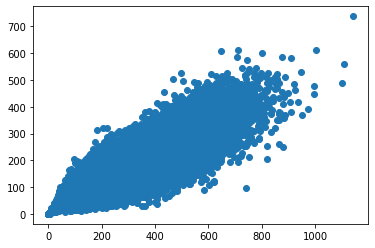

In [15]:
import matplotlib.pyplot as plt 
%matplotlib inline 

plt.scatter(y=sample['ride_duration'],x=sample['modified_active_time'])

plt.show()

In [9]:
def get_final_df_reg(use_cache=True):
    cache_path = os.path.join(CACHE_DIR, f'final_df_reg.msgpack')
    if os.path.exists(cache_path) and use_cache:
        print(f'{cache_path} exists')
        df_final = pd.read_msgpack(cache_path)
    else:
        start = '2016-11-01'
        end = '2016-11-30'
        orders = merge_order_df(start=start, end=end)
        print('orders')
               
        orders['hour'] = merged_orders.ride_start_timestamp.dt.hour
        orders['offpeak'] = (merged_orders.hour < 8) | (merged_orders.hour > 21) 
        
        # offpeak
        orders_offpeak = orders[orders.offpeak == True]
        target_df_offpeak = create_modified_active_time_through_decay(orders)

        # peak
        orders_peak = orders[orders.offpeak == False]
        target_df_peak = create_modified_active_time_through_decay(orders)
        
        # concat
        target_df = pd.concat([target_df_peak, target_df_offpeak], axis=0)
        target_df = target_df.groupby('driver_id').sum().reset_index()
        
        target_df['target'] = target_df['ride_duration'] / target_df[
            'modified_active_time']
        target_df.sort_values('driver_id', inplace=True)
        
        print('1e')
        df_final = create_features(
            start='2016-11-01', end='2016-11-30', use_cache=True)
        print('1f')
        spatial_df = get_spatial_features(orders)
        print('spatial')
        
        df_final = pd.merge(df_final, spatial_df, on=['driver_id'], how='inner')
        print(df_final.shape)
        df_final = pd.merge(df_final, target_df[['driver_id', 'inactive_time']], on=['driver_id'], how='inner')
        print(df_final.shape)
        df_final.sort_values('driver_id', inplace=True)
        df_final.set_index('driver_id', inplace=True)
#         pd.to_msgpack(cache_path, df_final)
    return df_final, target_df

In [10]:
X,y = get_final_df_reg(False)

/mnt/d/DiDi_Ride_Data/Ride_Data_Cache/merged_orders.msgpack exists
orders


KeyboardInterrupt: 

In [13]:
list(X.columns)

['num_total_rides',
 'num_pool_rides',
 '% of pool rides',
 '(332903.267, 345801.219](3379575.462, 3389679.747]',
 '(345801.219, 358571.469](3339057.28, 3349262.607]',
 '(345801.219, 358571.469](3359366.892, 3369471.177]',
 '(345801.219, 358571.469](3379575.462, 3389679.747]',
 '(358571.469, 371341.718](3369471.177, 3379575.462]',
 '(358571.469, 371341.718](3379575.462, 3389679.747]',
 '(358571.469, 371341.718](3389679.747, 3399784.032]',
 '(358571.469, 371341.718](3399784.032, 3409888.316]',
 '(358571.469, 371341.718](3409888.316, 3419992.601]',
 '(358571.469, 371341.718](3419992.601, 3430096.886]',
 '(358571.469, 371341.718](3430096.886, 3440201.171]',
 '(371341.718, 384111.968](3359366.892, 3369471.177]',
 '(371341.718, 384111.968](3369471.177, 3379575.462]',
 '(371341.718, 384111.968](3379575.462, 3389679.747]',
 '(371341.718, 384111.968](3389679.747, 3399784.032]',
 '(371341.718, 384111.968](3399784.032, 3409888.316]',
 '(371341.718, 384111.968](3409888.316, 3419992.601]',
 '(3713

In [14]:
# X = df_final.drop(columns=['num_total_rides'])
# X = df_final

xtrain, xtest, ytrain, ytest = train_test_split(X, y['target'])

sc = StandardScaler()
xtrain_sc = sc.fit_transform(xtrain)

rr = RandomForestRegressor()
rr.fit(xtrain_sc, ytrain)
rr.fit(xtrain_sc, ytrain)

#print(rr.coef_)
print(rr.score(xtrain_sc, ytrain))


0.8498598786495764


In [15]:
xtest_sc = sc.transform(xtest)
rr.score(xtest_sc, ytest)

0.6242913115007261